# `CLOUD.jl` - 2D linear advection

In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_dgsem_2D/";

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1342


Define the physical problem

In [2]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a DGSEM scheme of degree `p` with `M` elements

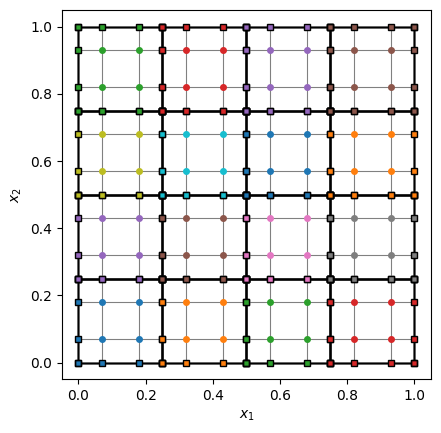

In [3]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Quad(), N_plot=ceil(Int,50/M), 
    volume_quadrature_rule=LGLQuadrature(),
    facet_quadrature_rule=LGLQuadrature())
spatial_discretization = SpatialDiscretization(
    uniform_periodic_mesh(reference_approximation.reference_element, 
        ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data,
     WeakConservationForm(), (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", plot_volume_nodes=true, grid_lines=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [4]:
reset_timer!()
n_s = 50
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            17.4s / 25.6%           4.97GiB / 59.4%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   15.9k    4.47s   100%   281μs   2.95GiB  100%    195KiB
   eval residual         254k    2.03s  45.5%  8.00μs   1.17GiB  39.6%  4.83KiB
     volume terms        254k    930ms  20.8%  3.66μs    915MiB  30.3%  3.69KiB
     facet terms         254k    318ms  7.13%  1.25μs    118MiB  3.92%     489B
     mass matrix solve   254k   79.9ms  1.79%   314ns   50.4MiB  1.67%     208B
   eval numerical flux   254k    493ms  11.0%  1.94μs    649MiB  21.5%  2.61KiB
   extrapolate solu...   254k    410ms 

Visualize the solution

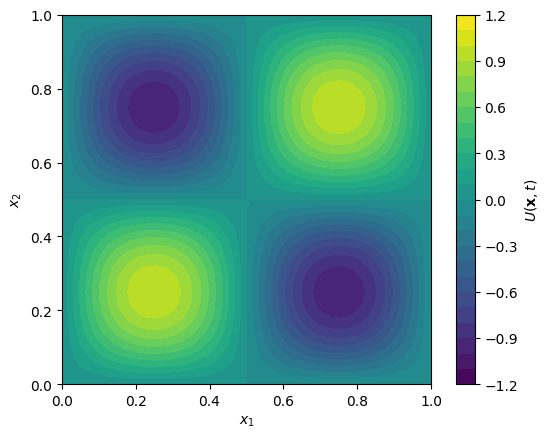

In [5]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

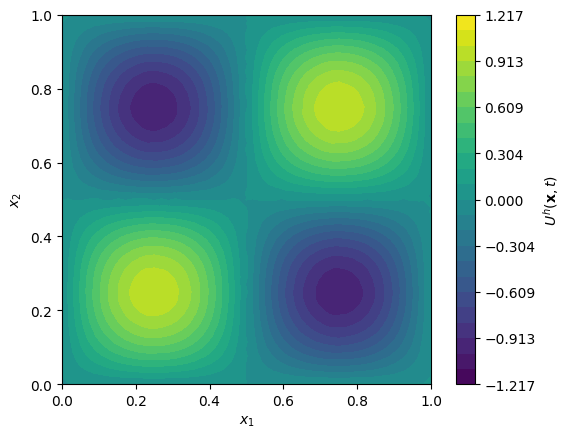

In [6]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [7]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.006003903208014296]
Conservation (initial/final/diff):
[-1.0408340855860843e-17][1.0061396160665481e-16][1.1102230246251565e-16]
Energy (initial/final/diff):
[0.2499999999999996][0.24999999999999226][-7.355227538141662e-15]
